<a href="https://colab.research.google.com/github/vedanthshenoy/Infy-stock-price-prediction-BiLSTM/blob/main/infy_share_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data=pd.read_csv('/content/drive/MyDrive/29-11-2018-TO-27-11-2020INFYALLN.csv',parse_dates=['Date'],index_col='Date')
data.head()

Symbol Series  ...  Deliverable Qty  % Dly Qt to Traded Qty
Date                      ...                                         
2018-11-29   INFY     EQ  ...          7390099                   55.15
2018-11-30   INFY     EQ  ...          6667707                   63.83
2018-12-03   INFY     EQ  ...          6137214                   74.29
2018-12-04   INFY     EQ  ...          4357939                   55.67
2018-12-05   INFY     EQ  ...          3101033                   59.90

[5 rows x 14 columns]

In [3]:
data['Day']=data.index.day
data['DayOfWeek']=data.index.dayofweek
data.head()

Symbol Series  Prev Close  ...  % Dly Qt to Traded Qty  Day  DayOfWeek
Date                                  ...                                        
2018-11-29   INFY     EQ      666.40  ...                   55.15   29          3
2018-11-30   INFY     EQ      661.05  ...                   63.83   30          4
2018-12-03   INFY     EQ      667.45  ...                   74.29    3          0
2018-12-04   INFY     EQ      670.35  ...                   55.67    4          1
2018-12-05   INFY     EQ      685.25  ...                   59.90    5          2

[5 rows x 16 columns]

In [4]:
data.drop(columns=['Symbol','Series'],inplace=True)
data.head()

Prev Close  Open Price  ...  Day  DayOfWeek
Date                                ...                
2018-11-29      666.40      671.00  ...   29          3
2018-11-30      661.05      661.00  ...   30          4
2018-12-03      667.45      673.15  ...    3          0
2018-12-04      670.35      672.55  ...    4          1
2018-12-05      685.25      683.00  ...    5          2

[5 rows x 14 columns]

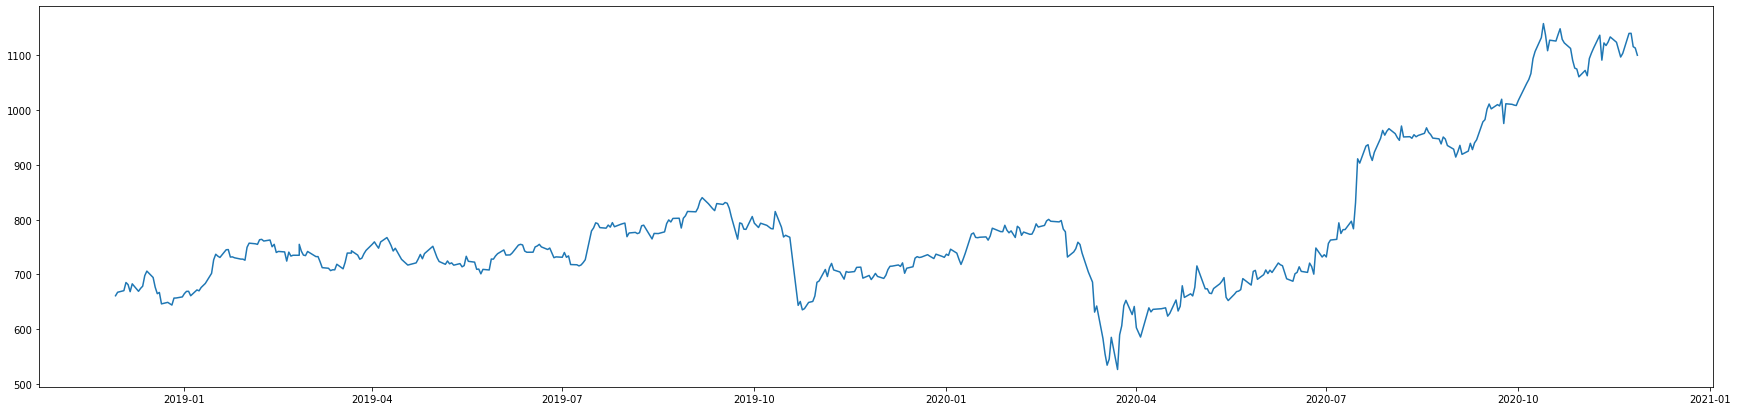

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,7))
plt.plot(data.index,data['Close Price'])
plt.show()

In [6]:
data_day=data.resample('D').sum()
data_day.head()

Prev Close  Open Price  ...  Day  DayOfWeek
Date                                ...                
2018-11-29      666.40      671.00  ...   29          3
2018-11-30      661.05      661.00  ...   30          4
2018-12-01        0.00        0.00  ...    0          0
2018-12-02        0.00        0.00  ...    0          0
2018-12-03      667.45      673.15  ...    3          0

[5 rows x 14 columns]

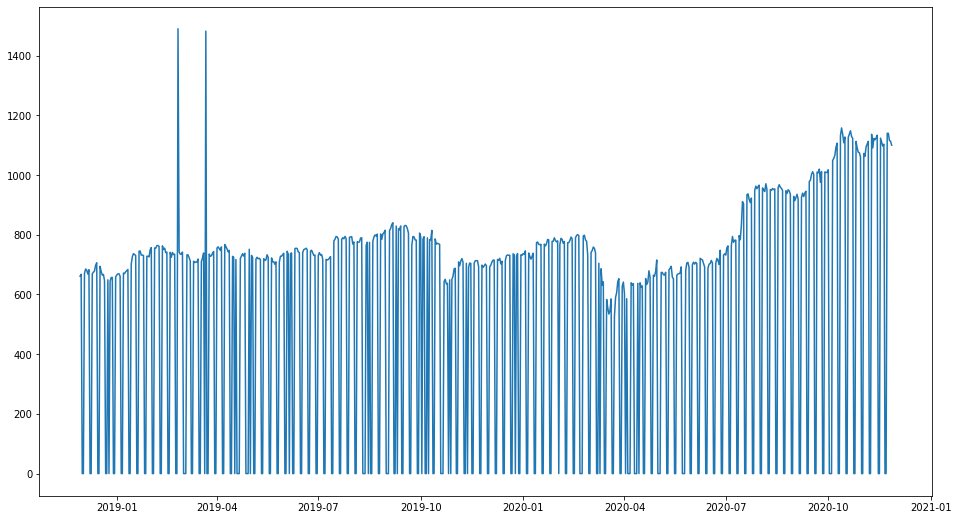

In [7]:
plt.figure(figsize=(16,9))
plt.plot(data_day.index,data_day.iloc[:,5].to_numpy())
plt.show()

In [8]:
train_size=int(len(data)*0.9)
train,test=data.iloc[:train_size],data.iloc[train_size:len(data)]
train.shape,test.shape

((449, 14), (50, 14))

In [9]:
from sklearn.preprocessing import MinMaxScaler

rs_data = MinMaxScaler()
rs_target = MinMaxScaler()

target=data['Close Price']
data.drop(columns=['Close Price'],inplace=True)

train.loc[:,data.columns]=rs_data.fit_transform(train.loc[:,data.columns].to_numpy())
train['Close Price']=rs_target.fit_transform(train[['Close Price']].to_numpy())
test.loc[:,data.columns]=rs_data.fit_transform(test.loc[:,data.columns].to_numpy())
test['Close Price']=rs_target.fit_transform(test[['Close Price']].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [10]:
import numpy as np
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [26]:
time_steps=3

x_train, y_train = create_dataset(train, train['Close Price'], time_steps)
x_test, y_test = create_dataset(test, test['Close Price'], time_steps)

x_train.shape,x_test.shape

((446, 3, 14), (47, 3, 14))

In [27]:
import keras
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(
  units=500,return_sequences=True
    )
  ))
model.add(
  keras.layers.Bidirectional(
  keras.layers.LSTM(units=500)
  )
)
model.add(keras.layers.Dropout(rate=0.25))
model.add(keras.layers.Dense(units=100,activation='relu'))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(units=1))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mse"])

In [28]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.35,
    shuffle=False,
    verbose=1
)

Epoch 1/10
10/10 [==============================] - 2s 208ms/step - loss: 0.0352 - mse: 0.0703 - val_loss: 0.0641 - val_mse: 0.1281
Epoch 2/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0107 - mse: 0.0214 - val_loss: 0.0206 - val_mse: 0.0413
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0080 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0387
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0041 - mse: 0.0082 - val_loss: 0.0221 - val_mse: 0.0443
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0023 - mse: 0.0046 - val_loss: 0.0169 - val_mse: 0.0337
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0029 - mse: 0.0057 - val_loss: 0.0133 - val_mse: 0.0267
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0031 - mse: 0.0061 - val_loss: 0.0106 - val_mse: 0.0213
Epoch 8/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0025 - 

In [29]:
pred=model.predict(x_test)
y_train_inv=rs_target.inverse_transform(y_train.reshape(1,-1))
y_test_inv=rs_target.inverse_transform(y_test.reshape(1,-1))
pred=rs_target.inverse_transform(pred.reshape(1,-1))

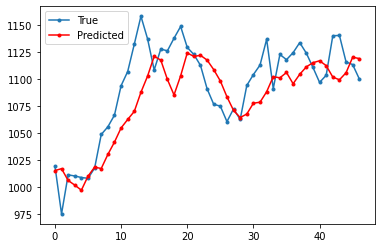

In [30]:
plt.plot(y_test_inv.flatten(),marker='.',label='True')
plt.plot(pred.flatten(),'r',marker='.',label='Predicted')
plt.legend()
plt.show()